# Survey Data Analysis for "Don't Let Me Be Misunderstood: Comparing Intentions and Perceptions in Online Conversations"

This notebook contains code to reproduce the survey response analyses found in the paper "Don't Let Me Be Misunderstood: Comparing Intentions and Perceptions in Online Conversations" (WWW '20) by Jonathan P. Chang, Justin Cheng, and Cristian Danescu-Niculescu-Mizil. Analyses are arranged to match the order in which they are presented in the paper.

Notebook author: Jonathan P. Chang (jpc362@cornell.edu)

Copyright (c) Facebook, Inc. and its affiliates.

This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import spacy
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import scale, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from matplotlib import pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from convokit import User, Utterance, Corpus, TextParser, PolitenessStrategies

## Load the data

Note: throughout the notebook, "survey A" is used to refer to the initiator survey and "survey B" is used to refer to the replier survey

In [2]:
survey_a_data = pd.read_csv("survey_a_responses_cached.tsv", sep="\t", lineterminator='\n', index_col=0)
survey_b_data = pd.read_csv("survey_b_responses_cached.tsv", sep="\t", lineterminator='\n', index_col=0)

In [3]:
# names of the columns corresponding to each variable/outcome we study
INTENT_COLS = ["joking", "info_giving", "info_seeking", "opinion_giving", "opinion_seeking"]
OUTCOME_COLS = ["understanding", "worth_time"]
EXTERN_OUTCOME_COLS = ["thread_length", "thread_incivility"]

In [4]:
# make sure we have the expected data size
print(survey_a_data.shape, survey_b_data.shape)

(9174, 49) (7129, 50)


## (Section 2.3) Exploring effects of survey participant demographics

Before we get into any real analysis, we first need to check whether demographic differences between the two surveys could have large enough effects to skew subsequent results.

First, let's check for overall differences in demographics (age / gender) between the responder pools of the two surveys.
Note that age is in years, and gender is encoded as 1 for female and 2 for male.

In [5]:
print("Kolmogrov-Smirnoff test results for difference in age distribution:", stats.ks_2samp(survey_a_data.age, survey_b_data.age))

Kolmogrov-Smirnoff test results for difference in age distribution: Ks_2sampResult(statistic=0.035597332205774164, pvalue=1.0)


In [6]:
gender_chisquare_results = sms.proportions_chisquare(
    [(survey_a_data.gender==1).sum(), (survey_b_data.gender==1).sum()],
    [survey_a_data.shape[0], survey_b_data.shape[0]]
)
print("Chi-squared test results for difference in gender distribution: statistic={}, pvalue={}".format(gender_chisquare_results[0], gender_chisquare_results[1]))

Chi-squared test results for difference in gender distribution: statistic=4.706892693859737, pvalue=0.030041905273139064


Next, let's check for possible correlations between demographics and responses

In [7]:
def compare_age_and_intents(responses):
    for intent in INTENT_COLS:
        # prevent numpy errors by dropping rows containing missing data
        responses_clean = responses.dropna(subset=[intent, "age"])
        correlation, pvalue = stats.spearmanr(responses_clean.age, responses_clean[intent])
        print("Spearman correlation between age and {}: {} (p={})".format(intent, correlation, pvalue))
        
print("Survey A age correlations:")
compare_age_and_intents(survey_a_data)
print()
print("Survey B age correlations:")
compare_age_and_intents(survey_b_data)

Survey A age correlations:
Spearman correlation between age and joking: -0.13541372443767377 (p=2.579478610177548e-38)
Spearman correlation between age and info_giving: 0.04996875464368345 (p=2.003962756342666e-06)
Spearman correlation between age and info_seeking: -0.08100243953950235 (p=1.3381377659766786e-14)
Spearman correlation between age and opinion_giving: 0.031088872248312964 (p=0.0031244563889842496)
Spearman correlation between age and opinion_seeking: -0.10519932377654269 (p=1.1530615190762386e-23)

Survey B age correlations:
Spearman correlation between age and joking: -0.07686089998153672 (p=1.0365132992077483e-10)
Spearman correlation between age and info_giving: 0.11936235203699506 (p=8.365878536178687e-24)
Spearman correlation between age and info_seeking: -0.029661500237895936 (p=0.012950449432018403)
Spearman correlation between age and opinion_giving: 0.025934690658819006 (p=0.029646227782742868)
Spearman correlation between age and opinion_seeking: -0.0118508005068

In [8]:
def compare_gender_and_intents(responses):
    for intent in INTENT_COLS:
        responses_clean = responses.dropna(subset=[intent, "gender"])
        intent_scores_female = responses_clean[responses_clean.gender==1][intent]
        intent_scores_male = responses_clean[responses_clean.gender==2][intent]
        u, p = stats.mannwhitneyu(intent_scores_female, intent_scores_male)
        print("Mean {} responses: {} for females, {} for males (Mann-Whitney U={}, p={})".format(intent, intent_scores_female.mean(), intent_scores_male.mean(), u, p))
        
print("Survey A gender vs response:")
compare_gender_and_intents(survey_a_data)
print()
print("Survey B gender vs response:")
compare_gender_and_intents(survey_b_data)

Survey A gender vs response:
Mean joking responses: 1.4301604668125456 for females, 1.759163802978236 for males (Mann-Whitney U=8371117.0, p=8.304569040664659e-44)
Mean info_giving responses: 3.1185171658144633 for females, 3.4094691535150647 for males (Mann-Whitney U=8630791.0, p=1.2399948448297029e-15)
Mean info_seeking responses: 2.419838945827233 for females, 2.2972661870503597 for males (Mann-Whitney U=9256584.0, p=0.016285921152196178)
Mean opinion_giving responses: 3.3343675853257895 for females, 3.618390804597701 for males (Mann-Whitney U=8670068.0, p=9.980157239423395e-15)
Mean opinion_seeking responses: 2.161802261948194 for females, 2.6424259844782982 for males (Mann-Whitney U=7737943.5, p=1.3523314259062852e-56)

Survey B gender vs response:
Mean joking responses: 1.6362106275547006 for females, 1.888533901313454 for males (Mann-Whitney U=5243929.0, p=2.0217829634166554e-18)
Mean info_giving responses: 3.3017282765242437 for females, 3.2039076376554174 for males (Mann-Whitn

Overall, we observe that (a) there are minor but significant demographic differences between replier pools in the two surveys, and (b) demographic variables may have a slight effect on survey responses. As noted in the paper, this motivates us to control for demographics as appropriate in subsequent analyses.

## (Section 3.1) Distributional differences between intentions and perceptions

The first way in which intentions and perceptions could differ is simply in terms of aggregate frequency: how often is a particular goal perceived to occur, compared to how often it is actually intended by the comment author? In this section, we address this question by computing the distribution of response scores for each goal on the initiator survey responses, and comparing this to the distribution as computed on the replier survey responses. This reproduces Figure 2 from the paper.

In [9]:
# As noted in the paper, for this analysis we control for demographics by using post-stratification to reweight the survey responses according
# to demographic distributions. This reweighting is done using post-stratification in R (see survey_reweighting.Rmd).
# In this notebook we simply load those precomputed reweighted responses.
precomputed_dists = pd.read_csv("survey_a_b_reweighted.tsv", sep="\t")

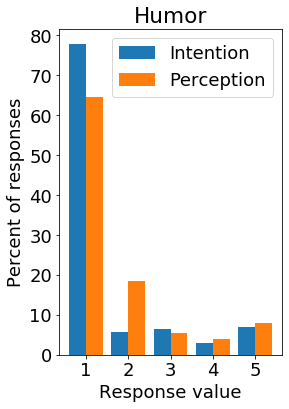

Ks_2sampResult(statistic=0.13881061589983806, pvalue=1.0)


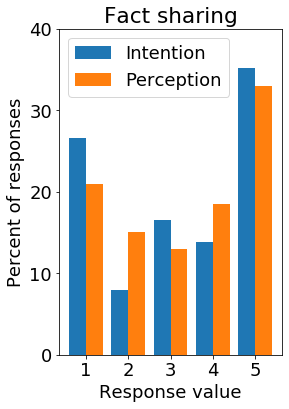

Ks_2sampResult(statistic=0.05327351630726941, pvalue=1.0)


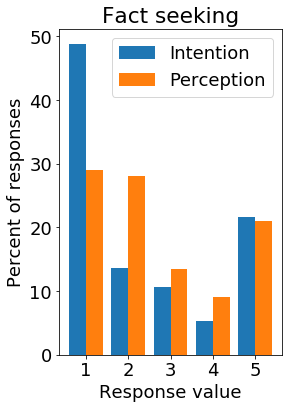

Ks_2sampResult(statistic=0.1965944911982527, pvalue=1.0)


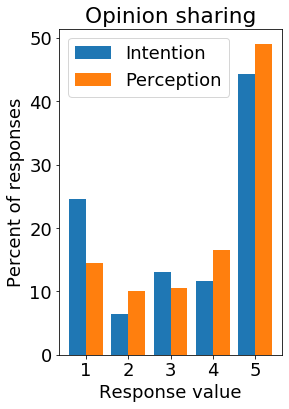

Ks_2sampResult(statistic=0.1003437752737149, pvalue=1.0)


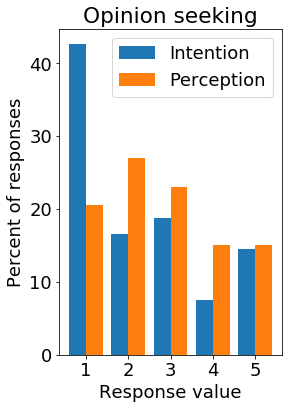

Ks_2sampResult(statistic=0.2178135480368431, pvalue=1.0)


In [10]:
# set up dimensions for the plots in this section
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (4,6)

# make the plot more readable by assigning human-friendly names to intents
human_readable_intents = {
    "joking": "Humor",
    "info_giving": "Fact sharing",
    "info_seeking": "Fact seeking",
    "opinion_giving": "Opinion sharing",
    "opinion_seeking": "Opinion seeking"
}

for intent in INTENT_COLS:
    # load reweighted frequencies from the file
    a_hist = precomputed_dists[(precomputed_dists.goal==intent)&(precomputed_dists.category=='intention')].Freq.values
    b_hist = precomputed_dists[(precomputed_dists.goal==intent)&(precomputed_dists.category=='perception')].Freq.values
    
    # draw the distributions side-by-side
    plt.bar(np.arange(5)-0.2, a_hist, width=0.4)
    plt.bar(np.arange(5)+0.2, b_hist, width=0.4)
    plt.xticks(np.arange(5), np.arange(1,6))
    # adaptive computation of y scale
    y_max = np.round(max(a_hist.max(), b_hist.max()),
                     decimals=1) + 0.1
    plt.yticks(np.arange(0,y_max,0.1), range(0,int(y_max*100),10))
    plt.ylabel("Percent of responses")
    plt.xlabel("Response value")
    plt.title(human_readable_intents[intent])
    plt.legend(["Intention", "Perception"])
    plt.show()
    # compute significance via K-S test
    print(stats.ks_2samp(survey_a_data[intent], survey_b_data[intent]))

We now explore the two types of systematic difference described in the paper. First, we look at systematic overestimation by comparing the means of the intention and perception distributions for each goal.

In [11]:
# As mentioned in the paper, we henceforth skip the humor goal type due to its relative rarity
for intent in INTENT_COLS[1:]:
    print("Overestimation calculation for goal", human_readable_intents[intent])
    a_hist = precomputed_dists[(precomputed_dists.goal==intent)&(precomputed_dists.category=='intention')].Freq.values
    b_hist = precomputed_dists[(precomputed_dists.goal==intent)&(precomputed_dists.category=='perception')].Freq.values
    # compute means for each distribution
    intention_mean = np.dot(a_hist, np.arange(5)+1)
    perception_mean = np.dot(b_hist, np.arange(5)+1)
    # compute Mann-Whitney U statistic for checking whether difference in means is significant
    print("\tMean intention score:", intention_mean)
    print("\tMean perception score:", perception_mean)
    print("\tMann-Whitney U test results:", stats.mannwhitneyu(survey_a_data[intent].dropna(), survey_b_data[intent].dropna()))

Overestimation calculation for goal Fact sharing
	Mean intention score: 3.2316705724807484
	Mean perception score: 3.29
	Mann-Whitney U test results: MannwhitneyuResult(statistic=31672294.5, pvalue=0.20157145395414705)
Overestimation calculation for goal Fact seeking
	Mean intention score: 2.3721892829175566
	Mean perception score: 2.665
	Mann-Whitney U test results: MannwhitneyuResult(statistic=27115014.0, pvalue=3.189843774490169e-60)
Overestimation calculation for goal Opinion sharing
	Mean intention score: 3.4446924880008942
	Mean perception score: 3.77
	Mann-Whitney U test results: MannwhitneyuResult(statistic=28858881.0, pvalue=7.644986541810479e-27)
Overestimation calculation for goal Opinion seeking
	Mean intention score: 2.3483986162258694
	Mean perception score: 2.785
	Mann-Whitney U test results: MannwhitneyuResult(statistic=25506090.0, pvalue=6.862963098563025e-109)


Next, we look at relative uncertainty (i.e. how likely survey responders are to give "extreme" scores of 1 or 5, as opposed to less certain scores of 2, 3, or 4, compared between intention and perception responses).

In [12]:
for intent in INTENT_COLS[1:]:
    a_hist = precomputed_dists[(precomputed_dists.goal==intent)&(precomputed_dists.category=='intention')].Freq.values
    b_hist = precomputed_dists[(precomputed_dists.goal==intent)&(precomputed_dists.category=='perception')].Freq.values
    # rescale frequences to weighted counts based on the original size of the data
    a_counts = a_hist * len(survey_a_data[intent].dropna())
    b_counts = b_hist * len(survey_b_data[intent].dropna())
    # the relative uncertainty score is computed as follows: for intention and perception responses, we compute the proportion of reponses
    # that gave scores of 2, 3, or 4 (i.e. "uncertain responses"). We then compare the frequencies for perception and intention responses
    # via chi-squared test, and take the chi-squared test statistic as the relative uncertainty score (higher score = more uncertainty)
    uncertainty_score, _, _ = sms.proportions_chisquare([np.sum(a_counts[1:4]), np.sum(b_counts[1:4])], [len(survey_a_data[intent].dropna()), len(survey_b_data[intent].dropna())])
    print("Relative uncertainty score for {}: {}".format(human_readable_intents[intent], uncertainty_score))

Relative uncertainty score for Fact sharing: 112.86368043243725
Relative uncertainty score for Fact seeking: 721.6302794440016
Relative uncertainty score for Opinion sharing: 60.51901708170341
Relative uncertainty score for Opinion seeking: 772.5048416934535


## (Section 3.2) Linguistic feature comparison

In this section, we extract some hand-engineered features representing potential linguistic cues of opinion and factuality. We then compare the relationship between these cues and intended opinion/fact sharing, to the relationship between these cues and perceived opinion/fact sharing. We are particularly interested in seeing whether there are any specific relationships that differ between intention and perception; that is, are there features that are predictive of intended opinion/fact sharing but not perceived, or vice versa? This reproduces Figure 3 from the paper.

In [13]:
# We use ConvoKit (convokit.cornell.edu) to extract some of the features (namely those related to politeness). So, we must first reformat the
# text data for use with ConvoKit.
placeholder_user = User(name="Facebook User") # ConvoKit asks for user info but for this pure linguistic analysis we don't need that, so we'll just put in a dummy.
utts = []
# since we do not have unique IDs for comments in the data, we'll set up our own custom identification scheme: {A/B}{number}{r?} where the first component
# identifies which survey this comment was used in, the second is just a numerical index corresponding to rows in the source data table, and the optional
# third component distinguishes replies from initial comments ("r" for replies, blank for initial)
for row in survey_a_data.itertuples():
    utts.append(Utterance(
        text=row.comment_text,
        id='A' + str(row.Index),
        root='A' + str(row.Index),
        reply_to=None,
        user=placeholder_user,
        timestamp=0,
        meta={
            'gender': row.gender,
            'age': row.age,
            'log_page_followers': row.log_page_followers,
            'page_category': row.page_super_category
        }
    ))
    utts.append(Utterance(
        text=row.reply_text,
        id='A' + str(row.Index)+'r',
        root='A' + str(row.Index),
        reply_to='A' + str(row.Index),
        user=placeholder_user,
        timestamp=0,
        meta={
            'gender': row.gender,
            'age': row.age,
            'log_page_followers': row.log_page_followers,
            'page_category': row.page_super_category
        }
    ))
for row in survey_b_data.itertuples():
    utts.append(Utterance(
        text=row.comment_text,
        id='B' + str(row.Index),
        root='B' + str(row.Index),
        reply_to=None,
        user=placeholder_user,
        timestamp=0,
        meta={
            'gender': row.gender,
            'age': row.age,
            'log_page_followers': row.log_page_followers,
            'page_category': row.page_super_category
        }
    ))
    utts.append(Utterance(
        text=row.reply_text,
        id='B' + str(row.Index)+'r',
        root='B' + str(row.Index),
        reply_to='B' + str(row.Index),
        user=placeholder_user,
        timestamp=0,
        meta={
            'gender': row.gender,
            'age': row.age,
            'log_page_followers': row.log_page_followers,
            'page_category': row.page_super_category
        }
    ))
corpus = Corpus(utterances=utts)

In [14]:
# extract politeness strategies using ConvoKit
corpus = TextParser().transform(corpus)
ps = PolitenessStrategies()
corpus = ps.transform(corpus)

In [15]:
# Other features will be extracted manually based on dependency parses and NER, both conducted using SpaCy.
spacy_nlp = spacy.load('en')
utt_ids = corpus.get_utterance_ids()
utts = [corpus.get_utterance(i).text for i in utt_ids]
parses = dict(zip(utt_ids, spacy_nlp.pipe(utts, n_threads=-1)))
for utterance in corpus.iter_utterances():
    utterance.meta['spacy'] = parses[utterance.id]

In [16]:
# feature vector generation

# manually-constructed lexicon of question words/phrases, derived from features discovered in Liu and Jansen (2015)
questions_lexicon = [
    'who',
    'what',
    'should',
    'good',
    'who is going',
    'where',
    'what time',
    'want'
]

def linguistic_feature_extractor(utt):
    # list of features that *don't* come from the politeness strategies
    feats = {
        'has_adjective': 0,
        'has_cardinal_num': 0,
        'has_modal': 0,
        'has_adverb': 0,
        'has_named_entity': 0,
        'question_lexicon': 0
    }
    # we don't use all politeness strategies, only those directly related to prior work on subjectivity detection
    kept_strats = set([
        'feature_politeness_==Hedges==',
        'feature_politeness_==Factuality==',
        'feature_politeness_==Please==',
        'feature_politeness_==1st_person==',
        'feature_politeness_==2nd_person==',
        'feature_politeness_==HASPOSITIVE==',
        'feature_politeness_==HASNEGATIVE=='
    ])
    # non-politeness features are extracted based on SpaCy language features
    for token in utt.meta['spacy']:
        if token.pos_ == 'ADJ':
            feats['has_adjective'] = 1
        if token.tag_ == 'CD':
            feats['has_cardinal_num'] = 1
        if token.tag_ == 'MD' and token.text.lower() != 'will':
            feats['has_modal'] = 1
        if token.pos_ == 'ADV' and token.text.lower()!= 'not':
            feats['has_adverb'] = 1
        if token.ent_type_ in set(['NORP', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'LAW', 'DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY']):
            feats['has_named_entity'] = 1
    if any(li in utt.text.lower() for li in questions_lexicon):
        feats['question_lexicon'] = 1
    # update the feature vector (currently containing features from `feats`) with the relevant politeness strategies
    feats.update({k: v for k, v in utt.meta['politeness_strategies'].items() if k in kept_strats})
    # additionally include demographic variables to act as controls in the regression analysis
    feats['age'] = utt.meta['age']
    feats['is_female'] = int(utt.meta['gender']==1)
    feats['log_page_followers'] = utt.meta['log_page_followers']
    return feats

In [17]:
# run feature extraction
survey_a_comment_idx = []
survey_a_comment_feats = []
survey_a_category_feats = []
survey_b_comment_idx = []
survey_b_comment_feats = []
survey_b_category_feats = []
for utt in corpus.iter_utterances():
    from_survey_a = 'A' in utt.id
    is_reply = ('r' in utt.id)
    feats = linguistic_feature_extractor(utt)
    if is_reply:
        continue
    true_id = int(utt.root[1:])
    if from_survey_a:
        survey_a_comment_idx.append(true_id)
        survey_a_comment_feats.append(feats)
        survey_a_category_feats.append(utt.meta['page_category'])
    else:
        survey_b_comment_idx.append(true_id)
        survey_b_comment_feats.append(feats)
        survey_b_category_feats.append(utt.meta['page_category'])

In [18]:
# features have now been extracted in the form of dictionaries mapping from feature name -> value.
# to reformat this for compatibility with statsmodels' regression functions, we now transform these into
# matrices, with the help of sklearn's DictVectorizer.
comment_feat_vect = DictVectorizer()
comment_feat_vect.fit(survey_a_comment_feats + survey_b_comment_feats)
survey_a_comment_feats = pd.DataFrame(comment_feat_vect.transform(survey_a_comment_feats).toarray(), 
                                      index=survey_a_comment_idx, columns=comment_feat_vect.get_feature_names())
survey_b_comment_feats = pd.DataFrame(comment_feat_vect.transform(survey_b_comment_feats).toarray(), 
                                      index=survey_b_comment_idx, columns=comment_feat_vect.get_feature_names())

In [19]:
# we additionally want to control for page category (a rough proxy for topic). But these are currently encoded
# as strings and hence cannot be regressed on. We convert these into one-hot vectors and join the resulting
# feature matrices with the previously generated comment feature matrices.
category_feat_vect = OneHotEncoder(sparse=False)
category_feat_vect.fit(np.asarray(survey_a_category_feats + survey_b_category_feats).reshape(-1,1))
survey_a_category_feats = pd.DataFrame(category_feat_vect.transform(np.asarray(survey_a_category_feats).reshape(-1,1)),
                                       index=survey_a_comment_idx, columns=category_feat_vect.get_feature_names())
survey_b_category_feats = pd.DataFrame(category_feat_vect.transform(np.asarray(survey_b_category_feats).reshape(-1,1)),
                                       index=survey_b_comment_idx, columns=category_feat_vect.get_feature_names())

In [20]:
# as previously mentioned, we join the comment feature matrices with the page category feature matrices
survey_a_feats = pd.concat((survey_a_comment_feats, survey_a_category_feats), axis=1)
survey_b_feats = pd.concat((survey_b_comment_feats, survey_b_category_feats), axis=1)
# we have features on different scales (most binary, some [age and page followers] numerical).
# this would prevent direct comparison of coefficients, so we standardize to get everything on the same scale.
survey_a_feats = pd.DataFrame(scale(survey_a_feats), index=survey_a_feats.index, columns=survey_a_feats.columns)
survey_b_feats = pd.DataFrame(scale(survey_b_feats), index=survey_b_feats.index, columns=survey_b_feats.columns)
# ensure index order is same as in original data
survey_a_feats = survey_a_feats.loc[survey_a_data.index]
survey_b_feats = survey_b_feats.loc[survey_b_data.index]

In [21]:
# reorder the columns so they look more logically ordered on the heatmap
COL_ORDER = [
    'has_adjective', 
    'has_adverb', 
    'feature_politeness_==1st_person==',
    'feature_politeness_==2nd_person==',
    'has_cardinal_num',
    'has_named_entity',
    'feature_politeness_==Hedges==',
    'feature_politeness_==Factuality==',
    'feature_politeness_==Please==',
    'question_lexicon',
    'feature_politeness_==HASPOSITIVE==',
    'feature_politeness_==HASNEGATIVE=='
]

In [22]:
# as we did with goals, we make a mapping of human readable versions of feature names to make the resulting plot easier to read.
human_readable_features = {
    'has_pronoun': 'Pronoun',
    'has_adjective': 'Adjective',
    'has_cardinal_num': 'Cardinal number',
    'has_modal': 'Modal',
    'has_adverb': 'Adverb',
    'has_polar': 'Polar word',
    'has_named_entity': 'Named entity',
    'question_lexicon': 'Question lexicon',
    'feature_politeness_==Please==': 'Please',
    'feature_politeness_==Please_start==': 'Please start',
    'feature_politeness_==Indirect_(btw)==': 'Indirect (btw)',
    'feature_politeness_==Hedges==': 'Hedging',
    'feature_politeness_==Factuality==': 'Factual language',
    'feature_politeness_==Deference==': 'Deference',
    'feature_politeness_==Gratitude==': 'Gratitude',
    'feature_politeness_==Apologizing==': 'Apologizing',
    'feature_politeness_==1st_person_pl.==': '1st person plural',
    'feature_politeness_==1st_person==': 'Pronoun (1st person)',
    'feature_politeness_==1st_person_start==': '1st person start',
    'feature_politeness_==2nd_person==': 'Pronoun (2nd person)',
    'feature_politeness_==2nd_person_start==': '2nd person start',
    'feature_politeness_==Indirect_(greeting)==': 'Greetings',
    'feature_politeness_==Direct_question==': 'Direct question',
    'feature_politeness_==Direct_start==': 'Direct start',
    'feature_politeness_==SUBJUNCTIVE==': 'Subjunctive',
    'feature_politeness_==INDICATIVE==': 'Indicative',
    'feature_politeness_==HASHEDGE==': 'Hedge (lexical)',
    'feature_politeness_==HASPOSITIVE==': 'Positive polar word',
    'feature_politeness_==HASNEGATIVE==': 'Negative polar word'
}

def run_language_analysis(responses, feat_table, title):
    rs = np.zeros([len(COL_ORDER),len(INTENT_COLS)-1])
    pvalues = np.zeros_like(rs)
    # run a regression analysis for each combination of goal and linguistic feature
    for i in range(len(COL_ORDER)):
        for j in range(len(INTENT_COLS)-1):
            intent = INTENT_COLS[j+1]
            feature = COL_ORDER[i]
            print("Running regression on combination ({}, {})".format(feature, intent))
            try:
                # regress on the feature of interest plus control variables
                regression_feats = feat_table[[feature, 'age', 'is_female', 'log_page_followers'] + category_feat_vect.get_feature_names().tolist()].dropna()
                has_intent = responses.loc[regression_feats.index,intent] > 3
                # run the regression (logistic regression via statsmodels)
                model = sm.Logit(has_intent.astype(int).values, sm.add_constant(regression_feats), method='bfgs')
                regression_results = model.fit()
            except np.linalg.LinAlgError:
                # extremely sparse feature tables may cause singular matrix error. in that case, we'll fall back to a simpler regression without the
                # page category features (since those are the sparsest parts of the table by virtue of being one-hot)
                # regress on the feature of interest plus control variables (note that this is empirically rare, occurring only for two of the combinations)
                print("[WARNING]: Singular Matrix error encountered. Falling back to regression without category features")
                regression_feats = feat_table[[feature, 'age', 'is_female', 'log_page_followers']].dropna()
                has_intent = responses.loc[regression_feats.index,intent] > 3
                model = sm.Logit(has_intent.astype(int).values, sm.add_constant(regression_feats), method='bfgs')
                regression_results = model.fit()
            rs[i,j] = regression_results.params.loc[feature]
            pvalues[i,j] = regression_results.pvalues.loc[feature]
    return rs, pvalues

In [23]:
# compute the tables of regression coefficients
a_rs, a_pvals = run_language_analysis(survey_a_data, survey_a_feats, "Language vs intents")
b_rs, b_pvals = run_language_analysis(survey_b_data, survey_b_feats, "Language vs perceptions")

Running regression on combination (has_adjective, info_giving)
         Current function value: 0.681964
         Iterations: 35
Running regression on combination (has_adjective, info_seeking)
         Current function value: 0.553583
         Iterations: 35
Running regression on combination (has_adjective, opinion_giving)
         Current function value: 0.666220
         Iterations: 35
Running regression on combination (has_adjective, opinion_seeking)


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastruct

         Current function value: 0.511583
         Iterations: 35
Running regression on combination (has_adverb, info_giving)
         Current function value: 0.682182
         Iterations: 35
Running regression on combination (has_adverb, info_seeking)
         Current function value: 0.556626
         Iterations: 35
Running regression on combination (has_adverb, opinion_giving)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.668401
         Iterations: 35
Running regression on combination (has_adverb, opinion_seeking)
         Current function value: 0.511998
         Iterations: 35
Running regression on combination (feature_politeness_==1st_person==, info_giving)
         Current function value: 0.684342
         Iterations: 35
Running regression on combination (feature_politeness_==1st_person==, info_seeking)
         Current function value: 0.557147
         Iterations: 35
Running regression on combination (feature_politeness_==1st_person==, opinion_giving)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.670043
         Iterations: 35
Running regression on combination (feature_politeness_==1st_person==, opinion_seeking)
         Current function value: 0.511782
         Iterations: 35
Running regression on combination (feature_politeness_==2nd_person==, info_giving)
         Current function value: 0.684455
         Iterations: 35
Running regression on combination (feature_politeness_==2nd_person==, info_seeking)
         Current function value: 0.557432
         Iterations: 35
Running regression on combination (feature_politeness_==2nd_person==, opinion_giving)
         Current function value: 0.670138
         Iterations: 35
Running regression on combination (feature_politeness_==2nd_person==, opinion_seeking)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

         Current function value: 0.511634
         Iterations: 35
Running regression on combination (has_cardinal_num, info_giving)
         Current function value: 0.681416
         Iterations: 35
Running regression on combination (has_cardinal_num, info_seeking)
         Current function value: 0.557132
         Iterations: 35
Running regression on combination (has_cardinal_num, opinion_giving)
         Current function value: 0.670069
         Iterations: 35
Running regression on combination (has_cardinal_num, opinion_seeking)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.511823
         Iterations: 35
Running regression on combination (has_named_entity, info_giving)
         Current function value: 0.680223
         Iterations: 35
Running regression on combination (has_named_entity, info_seeking)
         Current function value: 0.556972
         Iterations: 35
Running regression on combination (has_named_entity, opinion_giving)
         Current function value: 0.669778
         Iterations: 35
Running regression on combination (has_named_entity, opinion_seeking)
         Current function value: 0.512020
         Iterations: 35
Running regression on combination (feature_politeness_==Hedges==, info_giving)
         Current function value: 0.684565
         Iterations: 35
Running regression on combination (feature_politeness_==Hedges==, info_seeking)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

         Current function value: 0.557089
         Iterations: 35
Running regression on combination (feature_politeness_==Hedges==, opinion_giving)
         Current function value: 0.669205
         Iterations: 35
Running regression on combination (feature_politeness_==Hedges==, opinion_seeking)
         Current function value: 0.511913
         Iterations: 35
Running regression on combination (feature_politeness_==Factuality==, info_giving)
         Current function value: 0.684062
         Iterations: 35
Running regression on combination (feature_politeness_==Factuality==, info_seeking)
         Current function value: 0.556565
         Iterations: 35
Running regression on combination (feature_politeness_==Factuality==, opinion_giving)
         Current function value: 0.668738
         Iterations: 35
Running regression on combination (feature_politeness_==Factuality==, opinion_seeking)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

         Current function value: 0.512001
         Iterations: 35
Running regression on combination (feature_politeness_==Please==, info_giving)
         Current function value: 0.684120
         Iterations: 35
Running regression on combination (feature_politeness_==Please==, info_seeking)
         Current function value: 0.554334
         Iterations: 35
Running regression on combination (feature_politeness_==Please==, opinion_giving)
         Current function value: 0.669598
         Iterations: 35
Running regression on combination (feature_politeness_==Please==, opinion_seeking)
         Current function value: 0.511857
         Iterations: 35
Running regression on combination (question_lexicon, info_giving)
         Current function value: 0.684545
         Iterations: 35
Running regression on combination (question_lexicon, info_seeking)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

         Current function value: 0.556765
         Iterations: 35
Running regression on combination (question_lexicon, opinion_giving)
         Current function value: 0.668682
         Iterations: 35
Running regression on combination (question_lexicon, opinion_seeking)
         Current function value: 0.511164
         Iterations: 35
Running regression on combination (feature_politeness_==HASPOSITIVE==, info_giving)
         Current function value: 0.682888
         Iterations: 35
Running regression on combination (feature_politeness_==HASPOSITIVE==, info_seeking)
         Current function value: 0.548484
         Iterations: 35
Running regression on combination (feature_politeness_==HASPOSITIVE==, opinion_giving)
         Current function value: 0.661323
         Iterations: 35
Running regression on combination (feature_politeness_==HASPOSITIVE==, opinion_seeking)
         Current function value: 0.511520
         Iterations: 35
Running regression on combination (feature_politeness_=

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

         Current function value: 0.678910
         Iterations: 35
Running regression on combination (feature_politeness_==HASNEGATIVE==, info_seeking)
         Current function value: 0.549321
         Iterations: 35
Running regression on combination (feature_politeness_==HASNEGATIVE==, opinion_giving)
         Current function value: 0.661090
         Iterations: 35
Running regression on combination (feature_politeness_==HASNEGATIVE==, opinion_seeking)
         Current function value: 0.511998
         Iterations: 35
Running regression on combination (has_adjective, info_giving)
         Current function value: 0.684480
         Iterations: 35
Running regression on combination (has_adjective, info_seeking)
Optimization terminated successfully.
         Current function value: 0.583684
         Iterations 7
Running regression on combination (has_adjective, opinion_giving)
Optimization terminated successfully.
         Current function value: 0.635067
         Iterations 5
Running regre

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

Optimization terminated successfully.
         Current function value: 0.685596
         Iterations 5
Running regression on combination (has_adverb, info_seeking)
Optimization terminated successfully.
         Current function value: 0.585365
         Iterations 7
Running regression on combination (has_adverb, opinion_giving)
Optimization terminated successfully.
         Current function value: 0.637196
         Iterations 6
Running regression on combination (has_adverb, opinion_seeking)
Optimization terminated successfully.
         Current function value: 0.604179
         Iterations 5
Running regression on combination (feature_politeness_==1st_person==, info_giving)
Optimization terminated successfully.
         Current function value: 0.684385
         Iterations 5
Running regression on combination (feature_politeness_==1st_person==, info_seeking)
Optimization terminated successfully.
         Current function value: 0.585482
         Iterations 6
Running regression on combination

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.683121
         Iterations 4
Running regression on combination (has_cardinal_num, info_seeking)
         Current function value: 0.585463
         Iterations: 35
Running regression on combination (has_cardinal_num, opinion_giving)
Optimization terminated successfully.
         Current function value: 0.639448
         Iterations 9
Running regression on combination (has_cardinal_num, opinion_seeking)
Optimization terminated successfully.
         Current function value: 0.604159
         Iterations 5
Running regression on combination (has_named_entity, info_giving)
         Current function value: 0.682684
         Iterations: 35
Running regression on combination (has_named_entity, info_seeking)
Optimization terminated successfully.
         Current function value: 0.585172
         Iterations 7
Running regression on combination (has_named_entity, opinion_giving)
Optimization terminated successfully.
         Curre

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.584600
         Iterations 7
Running regression on combination (question_lexicon, opinion_giving)
Optimization terminated successfully.
         Current function value: 0.638414
         Iterations 7
Running regression on combination (question_lexicon, opinion_seeking)
Optimization terminated successfully.
         Current function value: 0.603160
         Iterations 5
Running regression on combination (feature_politeness_==HASPOSITIVE==, info_giving)
         Current function value: 0.684861
         Iterations: 35
Running regression on combination (feature_politeness_==HASPOSITIVE==, info_seeking)
         Current function value: 0.581209
         Iterations: 35
Running regression on combination (feature_politeness_==HASPOSITIVE==, opinion_giving)
         Current function value: 0.631987
         Iterations: 35
Running regression on combination (feature_politeness_==HASPOSITIVE==, opinion_seeking)
Optimization 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [24]:
# helper function for converting raw p values to star notation
def get_pstars(p):
    if p < 0.001:
        return "***"
    if p < 0.01:
        return "**"
    if p < 0.05:
        return "*"
    return ""

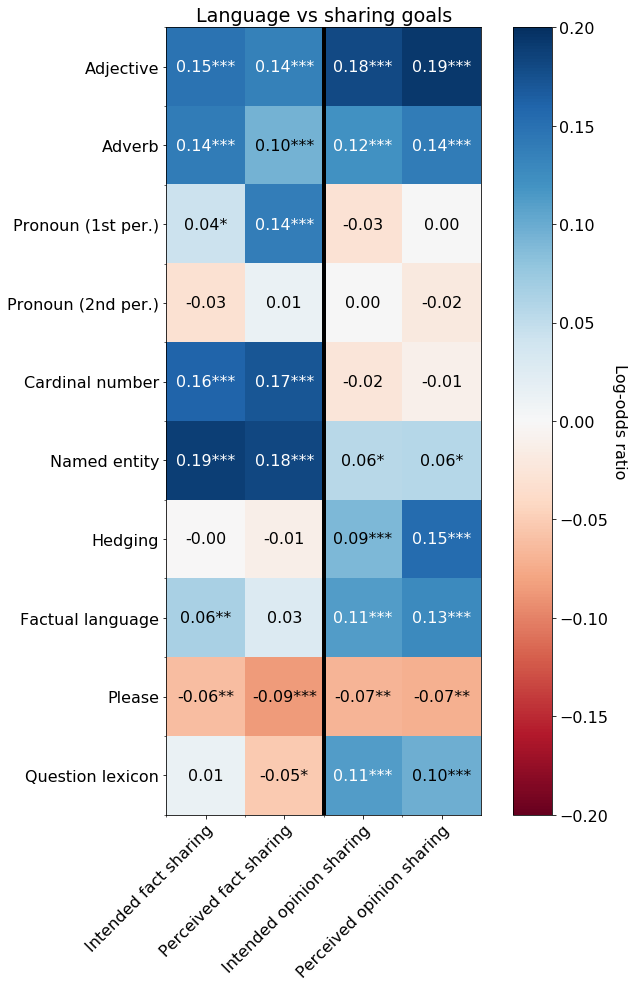

In [25]:
# plot the regressions

plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10,14)

# the regression code was run separately on intention and perception survey data, so we currently have separate result tables for intentions and perceptions.
# For ease of comparison we instead want to show coefficients for an intended and perceived goal side by side in the same table. Thus, we slice up the
# regression coefficient tables and rearrange the columns to achieve this. Note that in this cell we only do this for sharing-goals; we will do the same
# for seeking goals in the next cell.
rs = np.hstack((a_rs[:,0].reshape([-1,1]), b_rs[:,0].reshape([-1,1]), a_rs[:,2].reshape([-1,1]), b_rs[:,2].reshape([-1,1])))
pvalues = np.hstack((a_pvals[:,0].reshape([-1,1]), b_pvals[:,0].reshape([-1,1]), a_pvals[:,2].reshape([-1,1]), b_pvals[:,2].reshape([-1,1])))

rs = rs[:10,:]
ROWS = ['Adjective', 'Adverb', 'Pronoun (1st per.)', 'Pronoun (2nd per.)', 'Cardinal number', 'Named entity', 'Hedging', 'Factual language', 'Please', 'Question lexicon']
COLUMNS = ['Intended fact sharing', 'Perceived fact sharing', 'Intended opinion sharing', 'Perceived opinion sharing']

# code for plotting heatmaps (largely adapted from matplotlib docs)

fig, ax = plt.subplots()
ax.grid(False)
max_val = max(np.max(rs), abs(np.min(rs)))
im = ax.imshow(rs, cmap="RdBu", vmin=-0.2, vmax=0.2)

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Log-odds ratio", rotation=-90, va="bottom")

# We want to show all ticks...
ax.set_xticks(np.arange(len(COLUMNS)))
ax.set_yticks(np.arange(len(ROWS)))
# ... and label them with the respective list entries
ax.set_xticklabels(COLUMNS)
ax.set_yticklabels(ROWS)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.axvline(x=1.5, color='black', linewidth=4)

ax.set_xticks(np.arange(len(COLUMNS))-.5, minor=True)
ax.set_yticks(np.arange(len(ROWS)+1)-.5, minor=True)

# Loop over data dimensions and create text annotations.
for i in range(len(ROWS)):
    for j in range(len(COLUMNS)):
        text = ax.text(j, i, "{:.2f}{}".format(rs[i,j], get_pstars(pvalues[i,j])),
                       ha="center", va="center",
                       color="black" if abs(rs[i,j]) < 0.1 else "white")

plt.title("Language vs sharing goals")
fig.tight_layout()
plt.show()

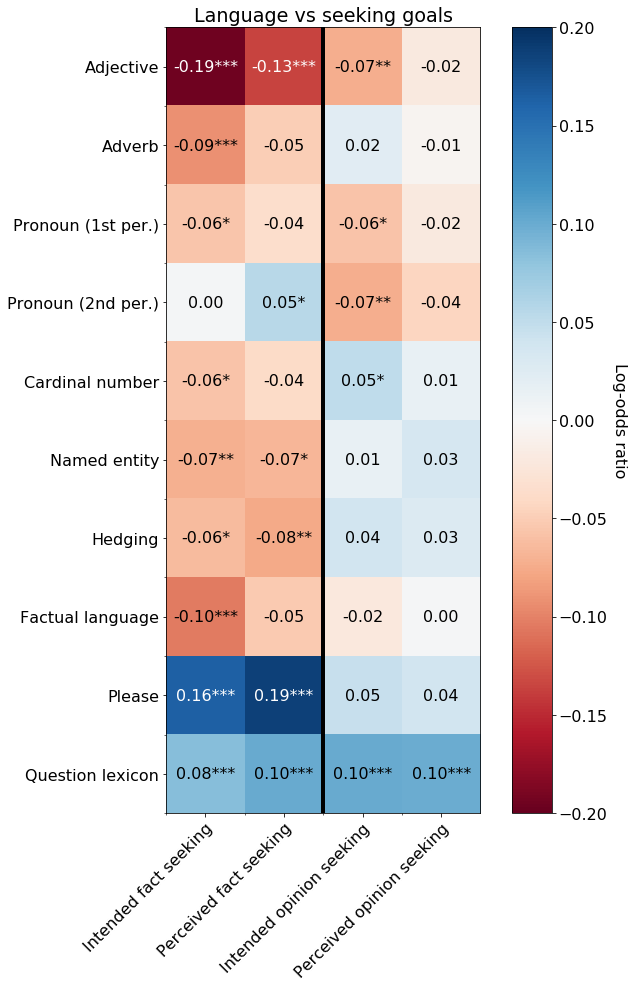

In [26]:
# repeat of the previous cell but for seeking-goals

plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10,14)

rs = np.hstack((a_rs[:,1].reshape([-1,1]), b_rs[:,1].reshape([-1,1]), a_rs[:,3].reshape([-1,1]), b_rs[:,3].reshape([-1,1])))
pvalues = np.hstack((a_pvals[:,1].reshape([-1,1]), b_pvals[:,1].reshape([-1,1]), a_pvals[:,3].reshape([-1,1]), b_pvals[:,3].reshape([-1,1])))

rs = rs[:10,:]
ROWS = ['Adjective', 'Adverb', 'Pronoun (1st per.)', 'Pronoun (2nd per.)', 'Cardinal number', 'Named entity', 'Hedging', 'Factual language', 'Please', 'Question lexicon']
COLUMNS = ['Intended fact seeking', 'Perceived fact seeking', 'Intended opinion seeking', 'Perceived opinion seeking']

fig, ax = plt.subplots()
ax.grid(False)
max_val = max(np.max(rs), abs(np.min(rs)))
im = ax.imshow(rs, cmap="RdBu", vmin=-0.2, vmax=0.2)

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Log-odds ratio", rotation=-90, va="bottom")

# We want to show all ticks...
ax.set_xticks(np.arange(len(COLUMNS)))
ax.set_yticks(np.arange(len(ROWS)))
# ... and label them with the respective list entries
ax.set_xticklabels(COLUMNS)
ax.set_yticklabels(ROWS)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.axvline(x=1.5, color='black', linewidth=4)

ax.set_xticks(np.arange(len(COLUMNS))-.5, minor=True)
ax.set_yticks(np.arange(len(ROWS)+1)-.5, minor=True)

# Loop over data dimensions and create text annotations.
for i in range(len(ROWS)):
    for j in range(len(COLUMNS)):
        text = ax.text(j, i, "{:.2f}{}".format(rs[i,j], get_pstars(pvalues[i,j])),
                       ha="center", va="center",
                       color="black" if abs(rs[i,j]) < 0.11 else "white")

plt.title("Language vs seeking goals")
fig.tight_layout()
plt.show()

## (Section 3.3) Comparing intentions and perceptions to conversational outcomes.

We now relate intended and perceived goals to various conversational outcomes. Some outcomes we consider are subjective ones from survey responses (worth-time and understanding/feeling understood) while others are observational (thread length and incivility). This reproduces Figure 4 from the paper.

In [27]:
# As before, we use a regression analysis to measure relationships. Since this one only involves data that is already in the
# survey response tables (rather than requiring any involved feature extraction) we encapsulate the conversion to statsmodels-ready
# matrix format in a single object (implemented as a sklearn Transformer) to streamline the subsequent code.

class FeatureExtractorForRegressionAnalysis(BaseEstimator, TransformerMixin):
    
    def __init__(self, intent):
        self.raw_feat_headers = [intent, "age", "log_page_followers"]
        self.gender_encoder = OneHotEncoder(sparse=False)
        self.page_type_encoder = OneHotEncoder(sparse=False)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        """X is a survey response table"""
        # first, gather the features that don't require any transformation (they are already on
        # meaningful numerical scales)
        raw_feats = X[self.raw_feat_headers]
        raw_feats = raw_feats.values
        # we'll consider only self-reported genders (all other cases are treated as unknown)
        gender_feat_map = {
            0: "gender_unknown",
            1: "gender_female",
            2: "gender_male",
            3: "gender_unknown",
            4: "gender_unknown"
        }
        gender_feats_str = X.gender.apply(lambda x: gender_feat_map[x])
        gender_feats = self.gender_encoder.fit_transform(gender_feats_str.values.reshape([-1,1]))
        # one-hot encoding of the page type
        page_feats = self.page_type_encoder.fit_transform(X.page_super_category.values.reshape([-1,1]))
        
        return np.hstack((raw_feats, gender_feats, page_feats))
    
    def get_feature_names(self):
        return np.concatenate((
            self.raw_feat_headers,
            self.gender_encoder.get_feature_names(),
            self.page_type_encoder.get_feature_names()
        ))

In [28]:
# another conversion of data table headers to human readable titles, this time for the outcomes.
human_readable_outcomes = {
    "understanding": "Understanding",
    "worth_time": "Time-worthiness",
    "thread_length": "Thread length",
    "thread_incivility": "Thread incivility"
}

def run_regression_analysis(responses, title):
    rs = np.zeros([len(OUTCOME_COLS+EXTERN_OUTCOME_COLS),len(INTENT_COLS)-1])
    pvalues = np.zeros_like(rs)
    # run a regression for each combination of goal and outcome
    for i in range(len(OUTCOME_COLS+EXTERN_OUTCOME_COLS)):
        for j in range(len(INTENT_COLS)-1):
            intent = INTENT_COLS[j+1]
            outcome = (OUTCOME_COLS+EXTERN_OUTCOME_COLS)[i]
            # drop nans to avoid breaking statsmodels
            cleaned_table = responses.dropna(subset=INTENT_COLS+[outcome, "age", "log_page_followers"])
            # extract regression features
            vectorizer = FeatureExtractorForRegressionAnalysis(intent)
            correlation_feats_df = pd.DataFrame(
                scale(vectorizer.transform(cleaned_table)),
                columns = vectorizer.get_feature_names()
            )
            # run the regression
            model = sm.OLS(scale(cleaned_table[outcome].astype(float).values), sm.add_constant(correlation_feats_df))
            regression_results = model.fit()
            rs[i,j] = regression_results.params.loc[intent]
            pvalues[i,j] = regression_results.pvalues.loc[intent]
    # with the tables constructed, we can now display the correlations as a heatmap.
    fig, ax = plt.subplots()
    ax.grid(False)
    max_val = max(np.max(rs), abs(np.min(rs)))
    im = ax.imshow(rs, cmap="RdBu", vmin=-max_val, vmax=max_val)
    
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(r"Relationship between intent and outcome (beta)", rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(INTENT_COLS)-1))
    ax.set_yticks(np.arange(len(OUTCOME_COLS+EXTERN_OUTCOME_COLS)))
    # ... and label them with the respective list entries
    ax.set_xticklabels([human_readable_intents[i] for i in INTENT_COLS[1:]])
    ax.set_yticklabels([human_readable_outcomes[i] for i in OUTCOME_COLS+EXTERN_OUTCOME_COLS])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    ax.set_xticks(np.arange(len(INTENT_COLS)-1)-0.5, minor=True)
    ax.set_yticks(np.arange(len(OUTCOME_COLS+EXTERN_OUTCOME_COLS)+1)-0.5, minor=True)

    # Loop over data dimensions and create text annotations.
    for i in range(len(OUTCOME_COLS+EXTERN_OUTCOME_COLS)):
        for j in range(len(INTENT_COLS)-1):
            text = ax.text(j, i, "{:.2f}{}".format(rs[i,j], get_pstars(pvalues[i,j])),
                           ha="center", va="center",
                           color="black" if abs(rs[i,j]) < 0.14 else "white")

    plt.title(title)
    fig.tight_layout()
    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is dep

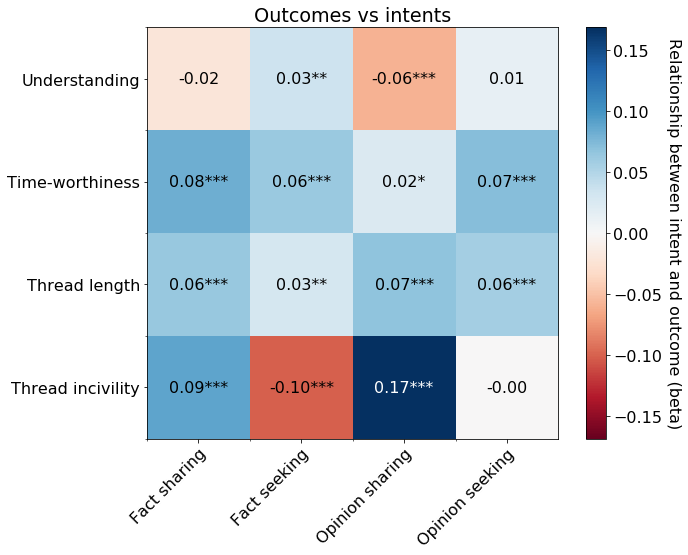

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is dep

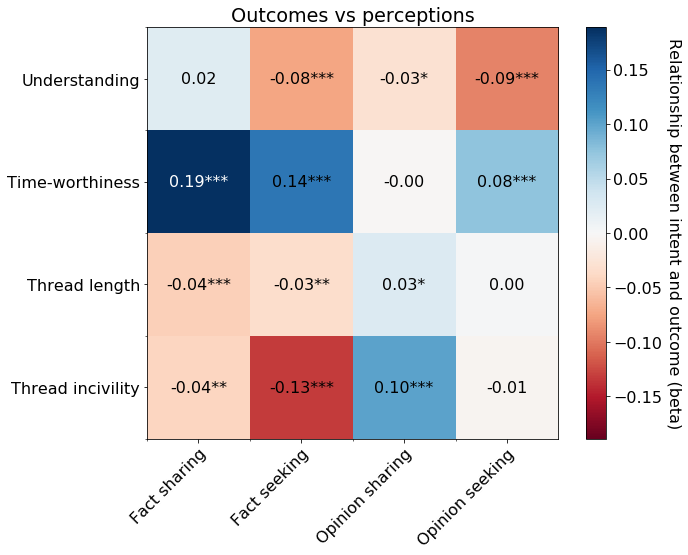

In [29]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10,8)
run_regression_analysis(survey_a_data, "Outcomes vs intents")
run_regression_analysis(survey_b_data, "Outcomes vs perceptions")

## (Section 4.1) Analysis of misperceived fact sharing using automatically generated labels

Section 4 of the paper investigates in more detail one case study of misperception: the case of intended fact sharing getting misperceived as opinion sharing. However, due to the lack of paired survey responses it is not possible to do this using only the survey responses. Thus, the paper looks at two methods for approximating paired labels, both of which keep initiator survey responses as ground-truth intention labels. The first method uses a machine learning model to predict perception labels, while the second method uses (small-scale) third-party annotation of perception. We now cover the first of these analyses, reproducing Figure 5 from the paper.

In [30]:
# A BERT-based classifier was used to produce predicted perception labels. Due to the complex boilerplate involved with setting up BERT and the
# computational resources needed to run it, these predictions were generated separately and in this notebook we simply load the already
# computed BERT results.

# first, reproduce the input that was sent to BERT (no rows can contain nan intent)
valid_samples_a = survey_a_data.dropna(subset=INTENT_COLS)

# load the BERT prediction results
survey_a_preds_raw = pd.read_csv("bert_predictions.tsv", sep="\t")
# override the index to enable joining (we know by construction the rows are in the same order already)
survey_a_preds_raw = survey_a_preds_raw.assign(idx=valid_samples_a.index.values).set_index("idx")
# join the results
survey_a_preds = valid_samples_a.join(survey_a_preds_raw.rename(columns={"label{}_pred".format(i): "{}_pred".format(INTENT_COLS[i]) for i in range(len(INTENT_COLS))}))

In [31]:
# define filter conditions for the intents we are interested in: namely, cases that were intended *only* as fact sharing, and
# (as a form of control) cases that were intended *only* as opinion sharing.
ig_only_cond = (survey_a_preds.info_giving > 3)&(survey_a_preds.opinion_giving < 3)
og_only_cond = (survey_a_preds.info_giving < 3)&(survey_a_preds.opinion_giving > 3)

# assign labels saying which rows meet which filters, for use with seaborn
survey_a_filtered = survey_a_preds.assign(intent_type=np.nan)
survey_a_filtered.loc[ig_only_cond,"intent_type"] = "Info giving only"
survey_a_filtered.loc[og_only_cond,"intent_type"] = "Opinion giving only"
# ...and then filter the table
survey_a_filtered = survey_a_filtered.dropna(subset=["intent_type"])

In [32]:
# convert raw scores into quintiles, to produce a cleaner plot
def score_to_quintile(score, quintile_cutoffs):
    for i, c in enumerate(quintile_cutoffs):
        if score < c:
            return i
    return 4

def error_bar_plot(intent_type, perception_column, outcome='thread_incivility', dodge=0):
    intent_data = survey_a_filtered[survey_a_filtered.intent_type==intent_type]
    # compute qunitile cutoffs in specified perception score column
    quintile_cutoffs = [np.percentile(intent_data[perception_column], i) for i in range(20,120,20)]
    # convert raw scores to quintiles
    scores_quintile = intent_data[perception_column].apply(lambda x: score_to_quintile(x, quintile_cutoffs))
    # compute means and confidence intervals per quintile bucket
    means = np.zeros(5)
    ci_low = np.zeros(5)
    ci_high = np.zeros(5)
    for i in range(5):
        bucket = intent_data[scores_quintile==i]
        means[i] = bucket[outcome].dropna().mean()
        ci_lower, ci_upper = sms.DescrStatsW(bucket[outcome].dropna().values).tconfint_mean()
        ci_low[i] = ci_lower
        ci_high[i] = ci_upper
    # format CIs as matplotlib error bars
    error_low = means - ci_low
    error_high = ci_high - means
    errorbars = np.vstack((error_low, error_high))
    # draw the plot
    plt.errorbar(np.arange(5)+dodge, means, yerr=errorbars, marker='o', capsize=20)

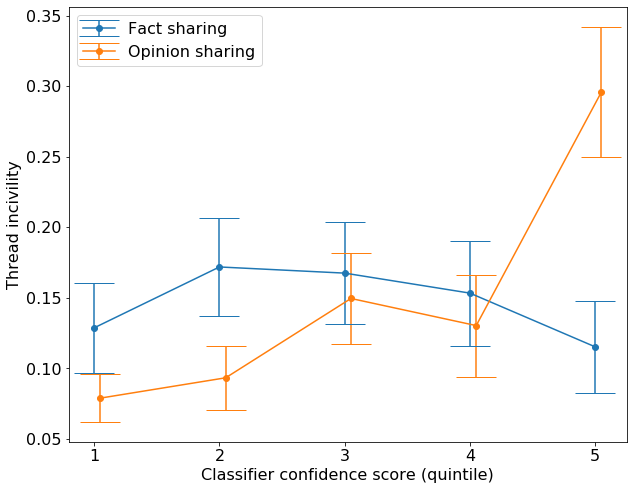

In [33]:
plt.figure()
error_bar_plot("Info giving only", "info_giving_pred")
error_bar_plot("Info giving only", "opinion_giving_pred", dodge=0.05)
plt.ylabel("Thread incivility")
plt.xlabel("Classifier confidence score (quintile)")
plt.xticks(np.arange(5), np.arange(5)+1)
plt.legend(["Fact sharing", "Opinion sharing"])
fig = plt.gcf()
plt.show()

## (Section 4.2) Analysis of misperceived fact sharing using human annotation

Finally, we consider the second version of the misperception analysis, using human annotation for perception labels. As noted in the paper, the scale of human annotation was quite small so this is largely intended as a validation of the classifier-based results.

In [34]:
# load annotation data
response_chunks = []
labels = []
incivility = []
for chunk_idx in list(range(11)):
    response_chunks.append(pd.read_csv("annotations/responses/annotation_samples_%d.tsv" % chunk_idx, sep="\t").assign(labeler=chunk_idx))
    with open("annotations/labels/annotation_samples_%d_labels.txt" % chunk_idx) as fp:
        labels += [1 if line.strip() == 'opinion' else -1 for line in fp]
    with open("annotations/labels/annotation_samples_%d_incivility.txt" % chunk_idx) as fp:
        incivility += [float(line.strip()) for line in fp]
annots = pd.concat(response_chunks)
annots['label'] = labels
annots['thread_incivility'] = incivility

In [35]:
# to avoid potential annotator bias, the sampled data included both cases intended as fact sharing (these are the ones we are interested in)
# and cases intended as opinion sharing. We filter out the latter prior to analysis.
annots_info_only = annots[annots.label==-1].dropna(subset=['thread_incivility'])
# now we split the table into cases perceived (by annotators) as opinions, and those perceived as facts
convert_label = lambda x: ('y' in str(x).lower() or x == 1)
incivility_perceived_info = annots_info_only[annots_info_only['Was the author of the comment sharing information?'].apply(convert_label)].thread_incivility
incivility_perceived_opinion = annots_info_only[annots_info_only['Was the author of the comment expressing an opinion?'].apply(convert_label)].thread_incivility
# ...and finally, compare the median incivility between the two splits, computing significance via Mann-Whitney test
print(incivility_perceived_info.median(), incivility_perceived_opinion.median())
print(stats.mannwhitneyu(incivility_perceived_info, incivility_perceived_opinion, alternative='less'))

0.07 0.08900000000000001
MannwhitneyuResult(statistic=1655.5, pvalue=0.034947085066173146)
